# Simplest CausalABA with Gradual Semantics

This is a sandbox for a quick experiment with the simplest version of gradual causal ABA using the smallest set of rules possible, doing minimal changes to existing algorithms and minimal integration.

We will setup the ABAF (the one with simplified reversed rules), solve using GradualABA code, then greedy search strongest model using the ranking induced upon arrow assumptions by their dialectical strengths.

We will then measure SID to compare this model with existing causal ABA for the 3 bnlearn datasets.

In [1]:
import sys
sys.path.append("../..")  # Adjust the path to import from the parent directory
sys.path.append("../../aspforaba")
sys.path.append("../../GradualABA")

In [2]:
from aspforaba.src.aspforaba.abaf import ABAF
import src.causal_aba.assumptions as asms
import src.causal_aba.atoms as atoms
import networkx as nx
from src.utils.utils import unique_product, powerset

from GradualABA.ABAF import ABAF as GradualABAF
from GradualABA.semantics.bsafDiscreteModular import DiscreteModular
from GradualABA.semantics.modular.LinearInfluence import LinearInfluence
from GradualABA.semantics.modular.ProductAggregation import ProductAggregation
from GradualABA.semantics.modular.SetProductAggregation import SetProductAggregation
from GradualABA.semantics.modular import SumAggregation
from GradualABA.semantics.modular import QuadraticMaximumInfluence

In [3]:
def dep(X, Y, S):
    # is symmpetric with respect to X and Y
    if X > Y:
        X, Y = Y, X
    S = sorted(S)
    return f"dep_{X}_{Y}__" + '_'.join([str(i) for i in S])

def active_path(source, target, path_id: int, S: set):
    S = sorted(list(S))
    # is symmetric with respect to source and target
    if source > target:
        source, target = target, source
    return f"active_path_{source}_{target}__{path_id}__" + '_'.join([str(i) for i in S])


In [4]:
# setup the problem
import sys

sys.path.insert(0, '../../ArgCausalDisco/')
sys.path.insert(0, '../../notears/')

import time
from pathlib import Path
from src.utils.enums import Fact, RelationEnum
from src.utils.bn_utils import get_dataset
from ArgCausalDisco.utils.helpers import random_stability
from itertools import combinations

from ArgCausalDisco.cd_algorithms.PC import pc
from ArgCausalDisco.utils.graph_utils import initial_strength


ALPHA = 0.01
INDEP_TEST = 'fisherz'

SAMPLE_SIZE = 5000
RESULT_DIR = Path("./results/")

dataset_name = 'cancer'
seed = 2024

X_s, B_true = get_dataset(dataset_name,
                        seed=seed,
                        sample_size=SAMPLE_SIZE)

# get facts from pc
uc_rule = 5
data = X_s

random_stability(seed)
n_nodes = data.shape[1]
cg = pc(data=data, alpha=ALPHA, indep_test=INDEP_TEST, uc_rule=uc_rule,
        stable=True, show_progress=True, verbose=True)
facts = []

for node1, node2 in combinations(range(n_nodes), 2):
    test_PC = [t for t in cg.sepset[node1, node2]]
    for sep_set, p in test_PC:
        dep_type_PC = "indep" if p > ALPHA else "dep"
        init_strength_value = initial_strength(p, len(sep_set), ALPHA, 0.5, n_nodes)

        fact = Fact(
            relation=RelationEnum(dep_type_PC),
            node1=node1,
            node2=node2,
            node_set=set(sep_set),
            score=init_strength_value
        )

        if fact not in facts:
            facts.append(fact)
sorted_facts = sorted(facts, key=lambda x: x.score, reverse=True)


/homes/yh2024/gradual-sem-causal-aba/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:root:You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
INFO:root:You are using ``pytorch`` as the backend.
INFO:root:==================Loading cancer dataset==================
Generating for node: Dyspnoea: 100%|██████████| 5/5 [00:00<00:00, 506.94it/s]
INFO:root:Data shape: (5000, 5)
INFO:root:Number of true edges: 4
INFO:root:True BN edges: [('Pollution', 'Cancer'), ('Smoker', 'Cancer'), ('Cancer', 'Xray'), ('Cancer', 'Dyspnoea')]
INFO:root:DAG? True
INFO:root:True DAG shape: (5, 5), True DAG edges: 4
INFO:root:           Cancer  Dyspnoea  Pollution  Smoker  Xray
Cancer          0         1          0       0     1
Dyspnoea        0         0          0      

In [5]:
# Setup the ABAF with simplest rules

abaf = ABAF([], [], [])

In [6]:
# Add independence and dependence assumptions
n_nodes = X_s.shape[1]
print(f"Number of nodes: {n_nodes}")

Number of nodes: 5


In [7]:
# add arrow and noe assumptions
# In this simplest version we leave out mutual exclusion and acyclicity rules for simplicity
for X, Y in unique_product(range(n_nodes), repeat=2):
    if X < Y:
        abaf.add_asmpt(asms.arr(X, Y))
        abaf.add_contrary(asms.arr(X, Y),
                          asms.contrary(asms.arr(X, Y)))
        abaf.add_asmpt(asms.arr(Y, X))
        abaf.add_contrary(asms.arr(Y, X),
                          asms.contrary(asms.arr(Y, X)))
        abaf.add_asmpt(asms.noe(X, Y))
        abaf.add_contrary(asms.noe(X, Y),
                            asms.contrary(asms.noe(X, Y)))
        
        # Mutual exclusion rules
        for assumption1, assumption2 in unique_product([asms.arr(X, Y),
                                                        asms.arr(Y, X),
                                                        asms.noe(X, Y)], repeat=2):
            abaf.add_rule((asms.contrary(assumption2), [assumption1]))

In [8]:

graph = nx.complete_graph(n_nodes)

all_paths = dict()
for fact in facts:
    X, Y = fact.node1, fact.node2
    if (X, Y) not in all_paths:
        all_paths[(X, Y)] = [tuple(p) for p in nx.all_simple_paths(graph, source=X, target=Y)]


for fact in sorted_facts:
    X, Y, S = fact.node1, fact.node2, fact.node_set
    abaf.add_asmpt(dep(X, Y, S))
    abaf.add_contrary(dep(X, Y, S), 
                      asms.contrary(dep(X, Y, S)))
    abaf.add_asmpt(asms.indep(X, Y, S))
    abaf.add_contrary(asms.indep(X, Y, S), 
                      asms.contrary(asms.indep(X, Y, S)))
    
    abaf.add_rule((asms.contrary(dep(X, Y, S)), [asms.indep(X, Y, S)]))
    abaf.add_rule((asms.indep(X, Y, S), [asms.contrary(dep(X, Y, S))]))
    abaf.add_rule((asms.contrary(asms.indep(X, Y, S)), [dep(X, Y, S)]))
    abaf.add_rule((dep(X, Y, S), [asms.contrary(asms.indep(X, Y, S))]))

    # Independence supports no-edge
    abaf.add_rule((asms.noe(X, Y), [asms.indep(X, Y, S)]))

    paths = all_paths.get((X, Y))

    for path_id, path in enumerate(paths):
        abaf.add_asmpt(asms.blocked_path(X, Y, path_id, S))
        abaf.add_contrary(asms.blocked_path(X, Y, path_id, S), 
                          asms.contrary(asms.blocked_path(X, Y, path_id, S)))
        
        abaf.add_asmpt(active_path(X, Y, path_id, S))
        abaf.add_contrary(active_path(X, Y, path_id, S),
                          asms.contrary(active_path(X, Y, path_id, S)))
        
        abaf.add_rule((asms.contrary(active_path(X, Y, path_id, S)), [asms.blocked_path(X, Y, path_id, S)]))
        abaf.add_rule((asms.blocked_path(X, Y, path_id, S), [asms.contrary(active_path(X, Y, path_id, S))]))
        abaf.add_rule((asms.contrary(asms.blocked_path(X, Y, path_id, S)), [active_path(X, Y, path_id, S)]))
        abaf.add_rule((active_path(X, Y, path_id, S), [asms.contrary(asms.blocked_path(X, Y, path_id, S))]))

        # independence implies blocked path
        abaf.add_rule((asms.blocked_path(X, Y, path_id, S), [asms.indep(X, Y, S)]))

        # V structures implied by active paths
        for node in S:
            assert node not in (X, Y), "Node in S cannot be source or target of active path"
            if node in path:
                # get index of node in path
                node_index = path.index(node)
                prev_node, next_node = path[node_index - 1], path[node_index + 1]
                # collider: prev_node --> node <-- next_node
                abaf.add_rule((asms.arr(prev_node, node), [active_path(X, Y, path_id, S)]))
                abaf.add_rule((asms.arr(next_node, node), [active_path(X, Y, path_id, S)]))

In [9]:
len(abaf.idx_to_asmpt), len(abaf.idx_to_atom), len(abaf.rules)

(1526, 3052, 4988)

In [10]:
iccma_input = f"p aba {len(abaf.atom_to_idx)}\n"

for idx in abaf.idx_to_asmpt:
    iccma_input += f"a {idx}\n"
for assumption, contrary_set in abaf.contraries.items():
    contrary = contrary_set.pop()  # assuming there's only one contrary per assumption
    iccma_input += f"c {assumption} {contrary}\n"
for head, body in abaf.rules:
    iccma_input += f"r {head} {' '.join(map(str, body))}\n"

iccma_input_path = Path("./iccma_input.aba")
with open(iccma_input_path, 'w') as f:
    f.write(iccma_input)

In [11]:
gradual_abaf = GradualABAF(path=iccma_input_path)

In [12]:
# Manualy give strengths to independence and dependence assumptions
idx_to_assumption = {asmp.name: asmp for asmp in gradual_abaf.assumptions}

for fact in sorted_facts:
    indep_asmp_name = asms.indep(fact.node1, fact.node2, fact.node_set)
    dep_asmp_name = dep(fact.node1, fact.node2, fact.node_set)

    indep_asmp_index = abaf.asmpt_to_idx[indep_asmp_name]
    dep_asmp_index = abaf.asmpt_to_idx[dep_asmp_name]

    scaled_score = 0.5 + fact.score / 2  # Scale score to [0.5, 1]

    if fact.relation == RelationEnum.dep:
        dep_strength = scaled_score
        indep_strength = 1 - scaled_score
    else:
        dep_strength = 1 - scaled_score
        indep_strength = scaled_score

    idx_to_assumption[str(indep_asmp_index)].initial_weight = indep_strength
    idx_to_assumption[str(dep_asmp_index)].initial_weight = dep_strength


In [13]:
bsaf = gradual_abaf.to_bsaf()

Analysing rules: 100%|██████████| 4988/4988 [00:00<00:00, 898715.08it/s]


0.03s to build 8042 arguments


In [14]:
DELTA = 5
EPSILON = 5e-3

In [15]:
model_dfquad = DiscreteModular(BSAF=bsaf, aggregation=ProductAggregation(),                ## Attack/Support Aggregation (as per UP)
                               influence=LinearInfluence(conservativeness=1),              ## Influence (as per UP)
                               set_aggregation=SetProductAggregation())                    ## Set Attack/Support Aggregation

model_dfquad.solve(20, generate_plot=True, verbose=False)
per_arg_dfquad = model_dfquad.has_converged(epsilon=EPSILON, last_n=DELTA)


model_qe = DiscreteModular(BSAF=bsaf, aggregation=SumAggregation(),                   ## Attack/Support Aggregation (as per UP)
                           influence=QuadraticMaximumInfluence(conservativeness=1),    ## Influence (as per UP)
                           set_aggregation=SetProductAggregation())                    ## Set Attack/Support Aggreg
model_qe.solve(20, generate_plot=True, verbose=False)
per_arg_qe = model_qe.has_converged(epsilon=EPSILON, last_n=DELTA)


In [16]:
from matplotlib import pyplot as plt

def strengthplot(
    model,
    title="Untitled graph",
    wide=6,
    tall=4,
    cmap='turbo',
    dpi=90,
    linewidth_pt=1,
    alpha=0.5
):
    """
    Plots strength over time for each assumption in `model.graph_data`.

    model          -- a DiscreteModular (or similar) with graph_data populated
    """
    # 2) grab the time-series data
    graph_data = getattr(model, "graph_data",
                       getattr(model, "approximator", {}).get("graph_data", None))
    if not graph_data:
        raise ValueError("No graph_data found—run solve(..., generate_plot=True) first")
   
    # 4) make the axes
    fig, ax = plt.subplots(figsize=(wide, tall), dpi=dpi)
    # hide top & right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    cmap = plt.get_cmap(cmap)

    for name, seq in graph_data.items():
        xs = [t for (t, _) in seq]
        ys = [v for (_, v) in seq]
        color = cmap(ys[-1])
        ax.plot(xs, ys, label=name, color=color, alpha=alpha, linewidth=linewidth_pt)

    ax.set_xlabel("Time (t)")
    ax.set_ylabel("Strength (t)")
    ax.set_title(title)

    ax.grid()
    return plt


<module 'matplotlib.pyplot' from '/homes/yh2024/gradual-sem-causal-aba/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

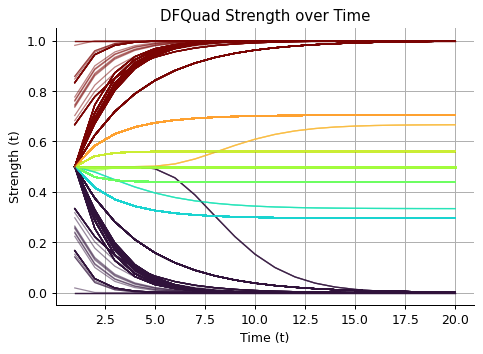

In [17]:
strengthplot(model_dfquad, title="DFQuad Strength over Time")

<module 'matplotlib.pyplot' from '/homes/yh2024/gradual-sem-causal-aba/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

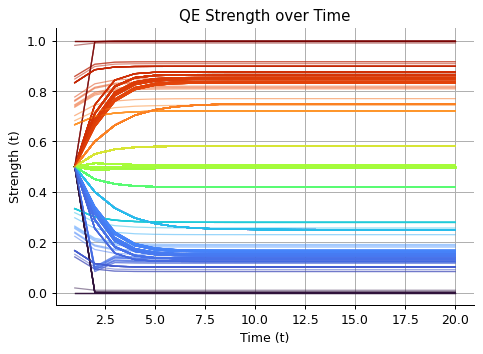

In [18]:
strengthplot(model_qe, title="QE Strength over Time")


In [19]:
import numpy as np
def plot_strengths_given_asms(ax,
                              model,
                              name_to_label,
                              title="Untitled graph",
                              alpha=0.5,
                              cmap='turbo',
                              linewidth_pt=1,
                              ):
    graph_data = getattr(model, "graph_data",
                       getattr(model, "approximator", {}).get("graph_data", None))
    if not graph_data:
        raise ValueError("No graph_data found—run solve(..., generate_plot=True) first")

    cmap = plt.get_cmap(cmap)
    
    for name, label in name_to_label.items():
        seq = graph_data[str(name)]
        xs = [t for (t, _) in seq]
        ys = [v for (_, v) in seq]
        color = cmap(np.random.rand())
        ax.plot(xs, ys, label=label, color=color, alpha=alpha, linewidth=linewidth_pt)

    ax.set_xlabel("Time (t)")
    ax.set_ylabel("Strength (t)")
    ax.set_title(title)

    ax.grid()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    return plt


<module 'matplotlib.pyplot' from '/homes/yh2024/gradual-sem-causal-aba/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

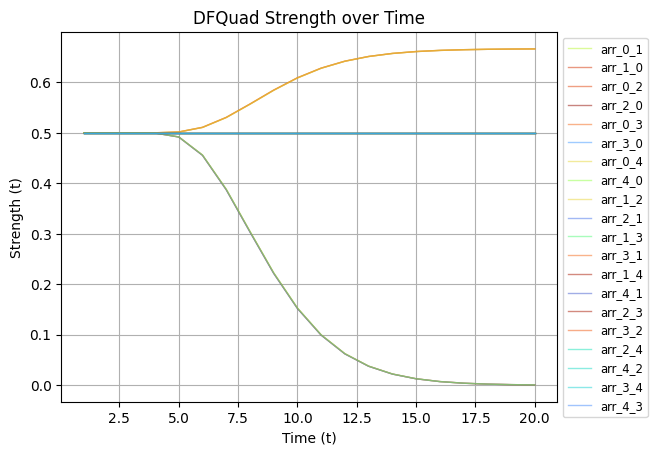

In [29]:
arr_asms = {idx: asm for idx, asm in abaf.idx_to_asmpt.items()
            if asm.startswith("arr_")}
noe_asms = {idx: asm for idx, asm in abaf.idx_to_asmpt.items()
            if asm.startswith("noe_")}

fig, ax = plt.subplots()

plot_strengths_given_asms(
    ax,
    model_dfquad,
    arr_asms,
    title="DFQuad Strength over Time")

In [30]:
graph_data = model_dfquad.graph_data

strengths = {label: graph_data[str(name)][-1][1] for name, label in arr_asms.items()}



In [31]:
strengths  # strengths got jumbled before reaching arrows

{'arr_0_1': np.float64(0.6662603957140893),
 'arr_1_0': np.float64(0.0006787171916955437),
 'arr_0_2': np.float64(0.6662613489560085),
 'arr_2_0': np.float64(0.0006758544153693813),
 'arr_0_3': np.float64(0.6662617614657174),
 'arr_3_0': np.float64(0.0006746155445123692),
 'arr_0_4': np.float64(0.6662589011809736),
 'arr_4_0': np.float64(0.0006832056919999219),
 'arr_1_2': np.float64(0.49999999991309074),
 'arr_2_1': np.float64(0.49999999991309074),
 'arr_1_3': np.float64(0.49999999991309074),
 'arr_3_1': np.float64(0.49999999991309074),
 'arr_1_4': np.float64(0.49999999991309074),
 'arr_4_1': np.float64(0.49999999991309074),
 'arr_2_3': np.float64(0.49999999991309074),
 'arr_3_2': np.float64(0.49999999991309074),
 'arr_2_4': np.float64(0.4999999999130907),
 'arr_4_2': np.float64(0.49999999991309074),
 'arr_3_4': np.float64(0.4999999999130907),
 'arr_4_3': np.float64(0.49999999991309074)}

<module 'matplotlib.pyplot' from '/homes/yh2024/gradual-sem-causal-aba/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

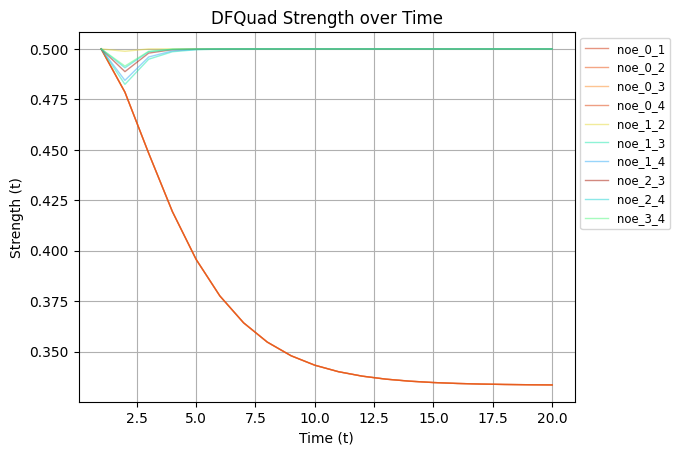

In [32]:
fig, ax = plt.subplots()

plot_strengths_given_asms(
    ax,
    model_dfquad,
    noe_asms,
    title="DFQuad Strength over Time")

In [33]:
strengths_noe = {label: graph_data[str(name)][-1][1] for name, label in noe_asms.items()}
strengths_noe

{'noe_0_1': np.float64(0.33351361001720164),
 'noe_0_2': np.float64(0.33351361000186175),
 'noe_0_3': np.float64(0.33351361000243074),
 'noe_0_4': np.float64(0.33351361000185953),
 'noe_1_2': np.float64(0.5),
 'noe_1_3': np.float64(0.4999999999979232),
 'noe_1_4': np.float64(0.4999999999997872),
 'noe_2_3': np.float64(0.49999999999999956),
 'noe_2_4': np.float64(0.5),
 'noe_3_4': np.float64(0.5)}

<module 'matplotlib.pyplot' from '/homes/yh2024/gradual-sem-causal-aba/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

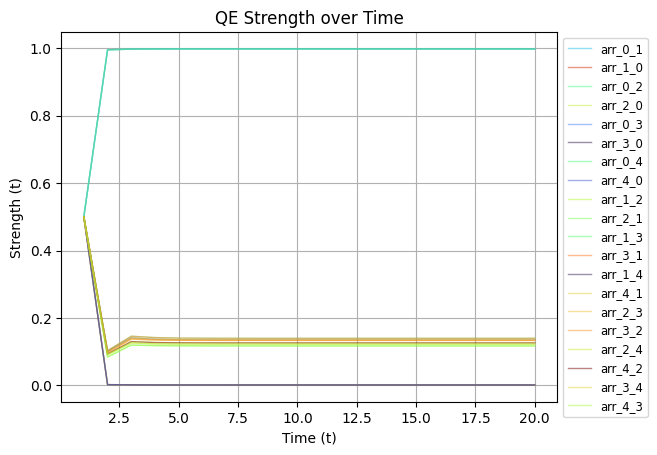

In [35]:
fig, ax = plt.subplots()

plot_strengths_given_asms(
    ax,
    model_qe,
    arr_asms,
    title="QE Strength over Time")

<module 'matplotlib.pyplot' from '/homes/yh2024/gradual-sem-causal-aba/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

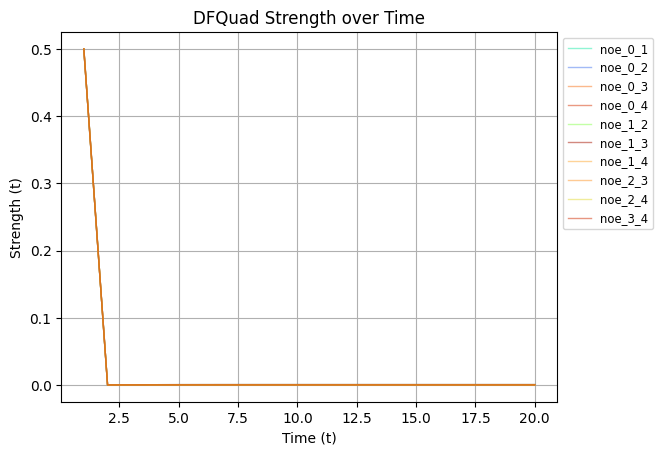

In [36]:
fig, ax = plt.subplots()

plot_strengths_given_asms(
    ax,
    model_qe,
    noe_asms,
    title="DFQuad Strength over Time")